In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy # lets us copy things
import seaborn as sns #seaborn is a wrapper for matplotlib
import tensorflow as tf
from sklearn.linear_model import LinearRegression

This dataset is licensed under a Creative Commons Attribution 4.0 International (CC BY 4.0) license.

# MODEL - SIMPLE LINEAR REGRESSION | SUPERVISED LEARNING
The main idea of linear regression is to fit a line (in 2D space), a plane (in 3D space), or a hyperplane (in higher dimensions) that best describes the relationship between the independent (input) and dependent (output) variables. This is accomplished by minimizing the sum of squares of the vertical deviations from each data point to the line (called residuals).
y = b0 + b1*x + e

where:

y is the dependent variable,
x is the independent variable,
b0 is the y-intercept,
b1 is the slope of the line (indicating the effect x has on y), and
e is the error term.

- trying to decrease the residual, "the line of error" for the linear prediction compared to the actual data plot

Training a linear regression model involves finding the values for the coefficients that minimize the sum of the squared residuals (also known as the loss function), usually using methods such as Gradient Descent or the Normal Equation.

# how to evaluate a linear regression model
R-Squared (Coefficient of Determination): This measures the proportion of variance in the dependent variable that can be predicted from the independent variable(s). It takes a value between 0 and 1, where a higher value generally indicates a better fit of the model. However, R-Squared doesn't tell the whole story, as it tends to increase with the addition of more predictors, regardless of whether they are truly meaningful.

Adjusted R-Squared: This is a modification of R-Squared that adjusts for the number of predictors in the model. Unlike R-Squared, the adjusted R-Squared increases only if the new term improves the model more than would be expected by chance.

Mean Squared Error (MSE) or Root Mean Squared Error (RMSE): These metrics represent the average squared difference or square root of that difference respectively between the observed and predicted values. It's a measure of the model's accuracy and lower values are desirable.

Mean Absolute Error (MAE): It represents the average of the absolute differences between the observed and predicted values. It's less sensitive to outliers compared to MSE or RMSE.

Residual Plots: Residuals are the difference between the observed and predicted values. Plotting these can give you an idea about the variance and whether it’s constant or not (homoscedasticity).

F-statistic: It is a statistical test used to compare our model with a reduced model (no predictors, just intercept). The null hypothesis states that the reduced model is better, and if the F-statistic is sufficiently large, this is evidence against the null hypothesis.

T-statistic/P-values: These are used for hypothesis testing on the coefficients. The null hypothesis states that the true coefficient is zero, i.e., the predictor has no effect on the outcome variable. If the p-value associated with a predictor is low (typically < 0.05), we reject the null hypothesis and say that the predictor is statistically significant.

Variance Inflation Factor (VIF): VIF measures the correlation and collinearity between the predictor variables in the model. If the VIF is high for a predictor variable (>5 or >10), it means that variable is highly correlated with the other predictor variables, and it might be more challenging to interpret its impact on the output variable.

In [5]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv("SeoulBikeData.csv").drop(["Date", "Holiday", "Seasons"], axis=1)


In [13]:
df.columns = dataset_cols #override the original df cloumn names
df["functional"] = (df["functional"] == "Yes").astype(int)
#index on a specific hour, so only the data from 12 oclock
df = df[df["hour"] == 12]
# now she dropped the column after the above, only the 12 oclock hours still show with no hour column
df = df.drop(["hour"], axis=1)

In [14]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,0
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,0
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,0
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,0
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,0


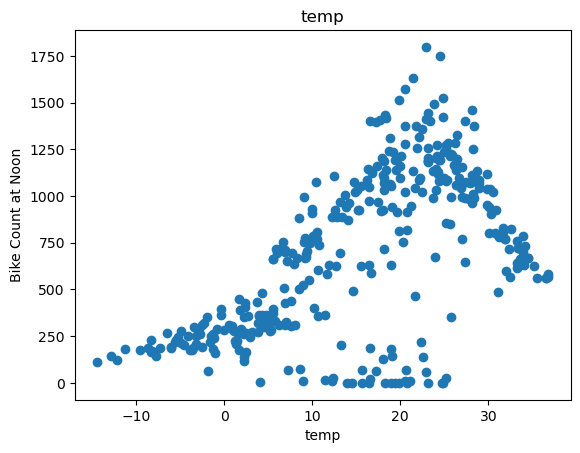

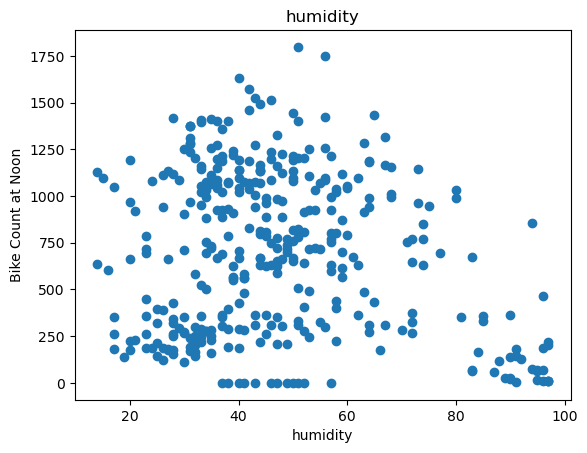

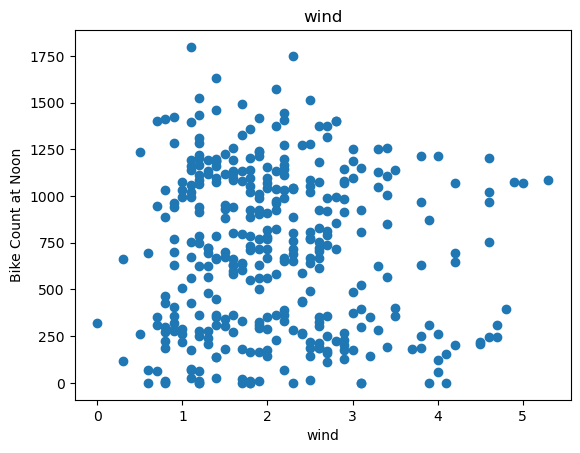

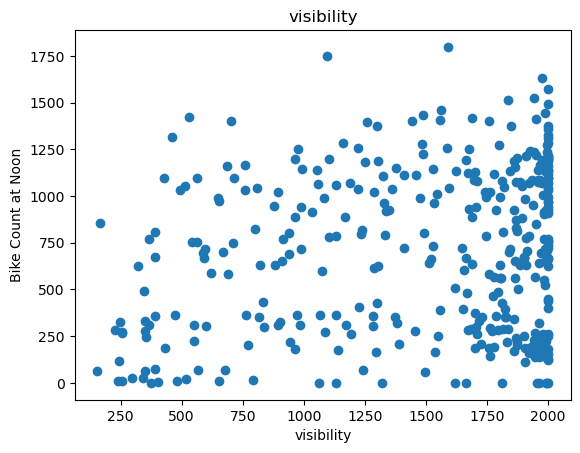

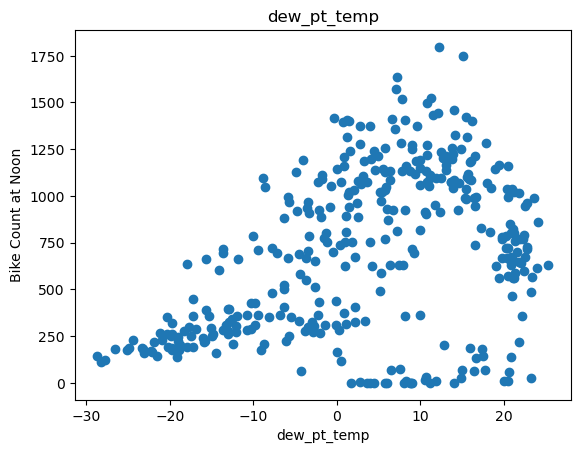

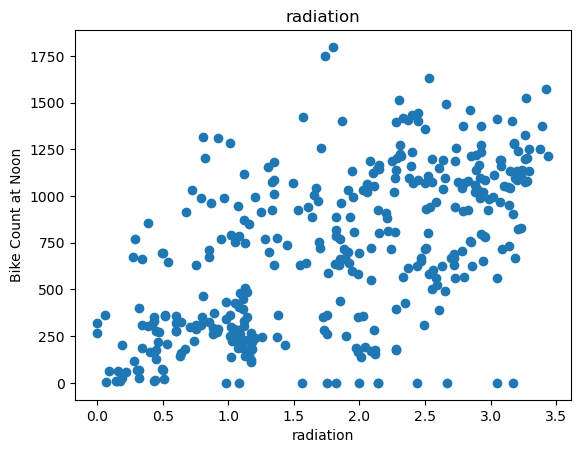

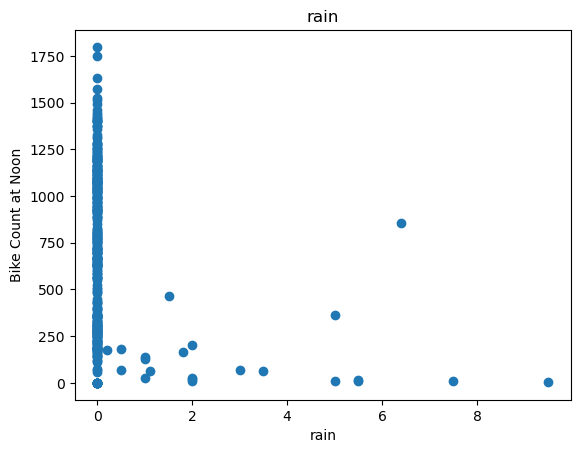

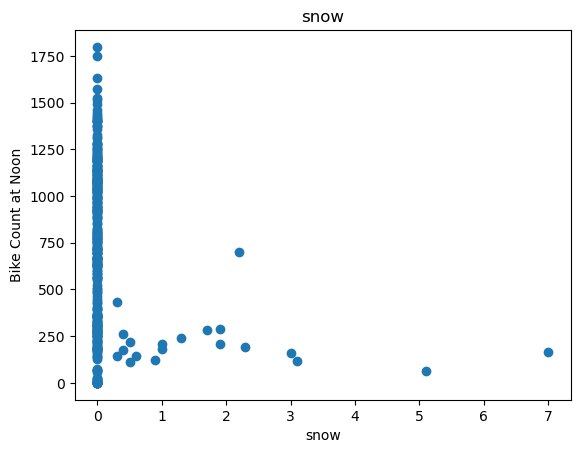

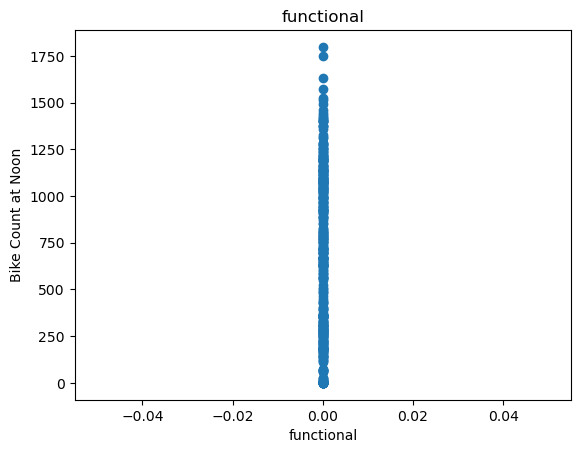

In [16]:
# plotting graphs
# for all columns after the first one (bike_count)
for label in df.columns[1:]:
    plt.scatter(df[label], df["bike_count"])    # name of the graph
    plt.title(label)                            # x axis graph title is the label
    plt.ylabel("Bike Count at Noon")
    plt.xlabel(label)                           # x axis = what the label is in the for loop interation
    plt.show()



In [18]:
# After the graph plot we drop the graphs that dont give us much utilty
df = df.drop(["wind", "visibility", "functional"], axis=1)

In [19]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


# SPLIT IN TRAINING/VALIDATION/TEST DATASET

In [20]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [46]:
# write a function to retrieve the x and y
def get_xy(dataframe, y_label, x_labels=None):
    dataframe = copy.deepcopy(dataframe)  # make a copy of the dataframe

    if x_labels is None:
        X = dataframe[[c for c in dataframe.columns if c != y_label]].values  # x is all the columns other than the y label
    else:
        if isinstance(x_labels, str):
            x_labels = [x_labels]  # Convert single label to a list
        if len(x_labels) == 1:
            X = dataframe[x_labels[0]].values.reshape(-1, 1)  # reshape just that label into a 2D array
        else:
            X = dataframe[x_labels].values  # X equals the values of the x labels

    y = dataframe[y_label].values.reshape(-1, 1)  # reshape the y label into a 2D array
    data = np.hstack((X, y))  # stack the X labels horizontally next to each other

    return data, X, y


In [47]:
# call the function -> the temp graph looked promising so we going to use that for now
_, X_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels="temp")
_, X_val_temp, y_val_temp = get_xy(val, "bike_count", x_labels="temp")
_, X_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels="temp")

In [48]:
# implementing the linear regression
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [49]:
temp_reg.score(X_test_temp, y_test_temp)

0.4088947315938035

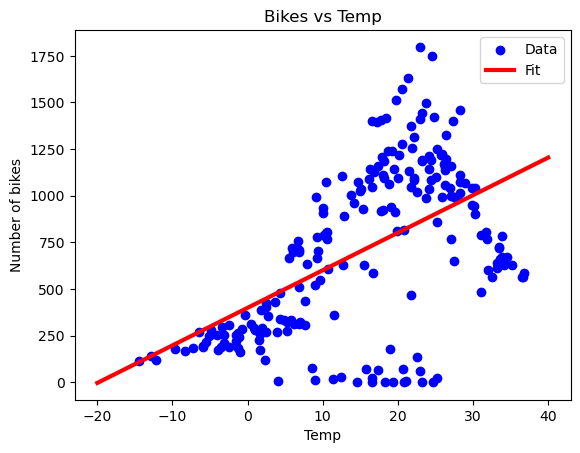

In [50]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

# MULITPLE LINEAR REGRESSION

In [51]:
df.columns

Index(['bike_count', 'temp', 'humidity', 'dew_pt_temp', 'radiation', 'rain',
       'snow'],
      dtype='object')

In [52]:
_, X_train_all, y_train_all = get_xy(train, "bike_count", x_labels=df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, "bike_count", x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "bike_count", x_labels=df.columns[1:])

In [53]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [54]:
all_reg.score(X_test_all, y_test_all)

0.5164710684267939

# Regression with neural net

In [62]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.show()

In [55]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

In [57]:
# call the normalizer for the neural net
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [59]:
# compile it
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [60]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(X_val_temp, y_val_temp)
)

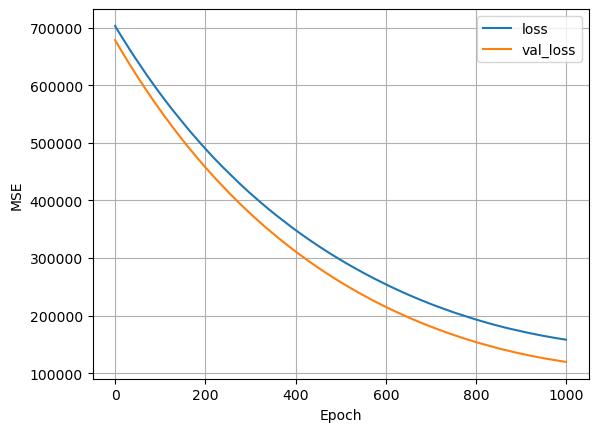

In [63]:
plot_loss(history)

4/4 [==============================] - 0s 2ms/step


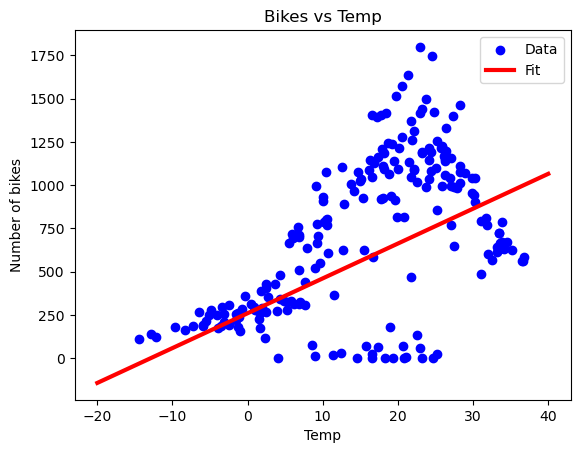

In [64]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

# BOOK MARK 3HOURS EXACT